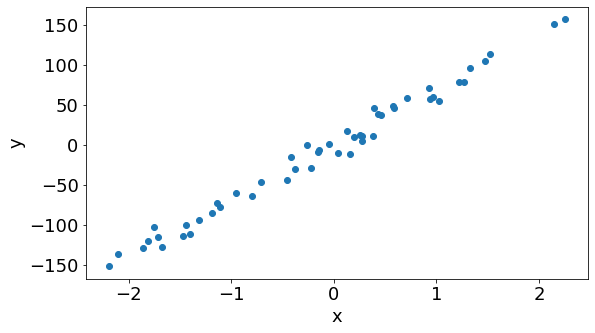

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
from scipy.stats import norm
import statsmodels.formula.api as smf

n=50
x, y = datasets.make_regression(n_samples=n,
                                n_features=1,
                                noise=10,
                               random_state=369)
# Plot data
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(x, y)
ax.ticklabel_format(style='plain')
plt.xlabel('x',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [13]:
data = pd.DataFrame({"x":x.flatten(),"y":y})

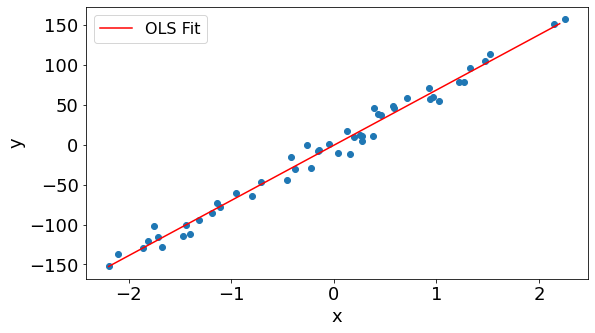

In [14]:
X=np.hstack([np.ones(n).reshape(-1,1),x])
betas=np.linalg.inv((X.T@X))@X.T@y
intercept = betas[0]
slope = betas[1]
x_vals = np.arange(min(x), max(x), 0.1)
ols_line = slope*x_vals + intercept
# Plot the OLS line
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(data['x'], data['y'])
ax.plot(x_vals, ols_line,label='OLS Fit', color='red')
ax.ticklabel_format(style='plain')
plt.xlabel('x',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.show()

In [66]:
results = smf.ols("y~x", data=data).fit()
resid=y-X@betas
resid_std = np.sqrt(sum(resid**2)/(n-1))

-0.5495211174204928

In [71]:
def make_uninformative_prior(name,data):
    """Function to make priors."""
    df = pd.DataFrame({name:data})
    df['Prior'] = 1/len(data)
    return df

# Create a range of values for the slope
data_slope = np.linspace(betas[1]*0.8,
                         betas[1]*1.2, num=60)
prior_slope = make_uninformative_prior('slope',data_slope)
prior_slope.head()
# Create a range of values for the intercept
data_inter = np.linspace(betas[0]*0.8,
                         betas[0]*1.2, num=60)
prior_inter = make_uninformative_prior('intercept',data_inter)
prior_inter.head()
# Create a range of values for the sigma
data_sigma = np.linspace(resid_std*0.8,
                         resid_std*1.2, num=60)
prior_sigma = make_uninformative_prior('sigma',data_sigma)
prior_sigma.head()

,sigma,Prior
0,7.832099,0.016667
1,7.898473,0.016667
2,7.964846,0.016667
3,8.031220,0.016667
4,8.097594,0.016667


In [3]:
prior_slope

NameError: name 'prior_slope' is not defined

In [11]:
# Counter for the row index
counter = 0

# Dataframe to store the combinations in
df = pd.DataFrame(columns=['slope','intercept','sigma','prior'])

# Iterate through the slope
for slope in prior_slope['slope']:
    prob_slope = prior_slope['Prior'].loc[prior_slope['slope'] == slope]
    
    # Iterate through the intercept
    for intercept in prior_inter['intercept']:
        prob_inter =  prior_inter['Prior'].loc[prior_inter['intercept'] == intercept]
        
        # Iterate through the error
        for sigma in prior_sigma['sigma']:
            prob_sigma = prior_sigma['Prior'].loc[prior_sigma['sigma'] == sigma]
            
            # Calculate the prior of this specific combination
            prob = \
            float(prob_slope)*float(prob_inter)*float(prob_sigma)
            
            # Insert the row of data
            df.loc[counter] = \
            [slope] + [intercept] + [sigma] + [prob]
            
            # Update row index
            counter += 1

KeyboardInterrupt: 

In [117]:
y_hat=[]
likelihood=[]
y_t=y.reshape(-1,1)

In [118]:
for i,r in df.iterrows():
    if i % 10000 == 0:
        print(i)
    y_hat.append(r['slope'] * x + r['intercept'])
    likelihood.append(np.prod(norm(0, r['sigma']).pdf(y_t-y_hat[i])))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000


In [119]:
df['likelihood']=likelihood

In [120]:
df['posterior'] = df['prior'] * df['likelihood']
df['posterior'] = df['posterior']/df['posterior'].sum()

In [121]:
slope_df = df.groupby('slope').sum()

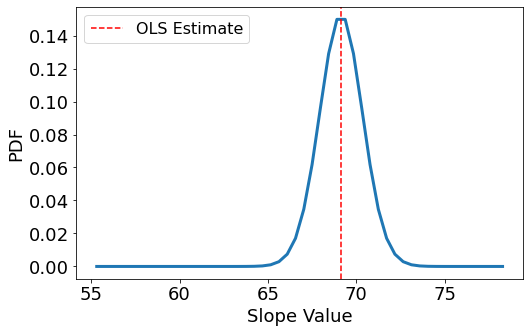

In [123]:
# Plot the posterior distribution of the slope
plt.figure(figsize=(8,5))
plt.plot(slope_df.index, slope_df.posterior, linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Slope Value', fontsize=18)
plt.ylabel('PDF', fontsize=18)
plt.axvline(results.params['x'], color='red', ls='--', label='OLS Estimate')
plt.legend(fontsize=16)
plt.show()

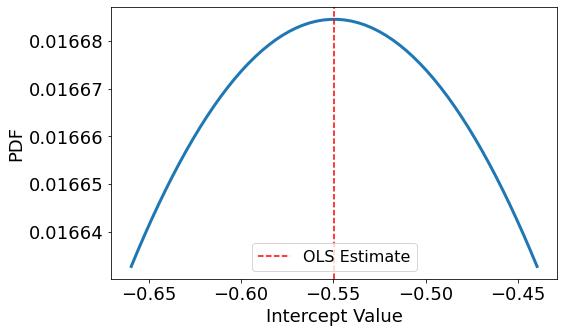

In [124]:
intercept_df = df.groupby('intercept').sum()
sigma_df = df.groupby('sigma').sum()
# Plot the posterior distribution of the Intercept
plt.figure(figsize=(8,5))
plt.plot(intercept_df.index, intercept_df.posterior, linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Intercept Value', fontsize=18)
plt.ylabel('PDF', fontsize=18)
plt.axvline(results.params['Intercept'], color='red', ls='--', label='OLS Estimate')
plt.legend(fontsize=16)
plt.show()

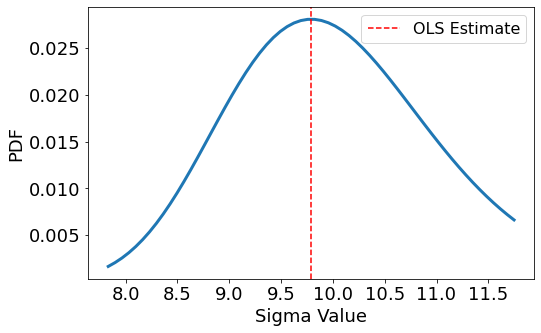

In [125]:
# Plot the posterior distribution of sigma
plt.figure(figsize=(8,5))
plt.plot(sigma_df.index, sigma_df.posterior, linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Sigma Value', fontsize=18)
plt.ylabel('PDF', fontsize=18)
plt.axvline(results.resid.std(), color='red', ls='--', label='OLS Estimate')
plt.legend(fontsize=16)
plt.show()